Try to see how similar the output of the GAN is with respect to the ground truth, to see if the model is overfitted or underfitted.
GANs are hard to evaluate in general -> https://stats.stackexchange.com/questions/482653/what-is-the-stop-criteria-of-generative-adversarial-nets

In [19]:
import os
import glob

from PIL import Image
# https://pypi.org/project/ImageHash/
import imagehash
import numpy as np

from matplotlib import pyplot as plt

In [173]:
def hash_image(img_path: str, method: str = 'average', hash_size: int=8) -> str:
    # implement the hashing methods of choice here
    img = Image.open(img_path)
    if method == 'average':
        hash_ = imagehash.average_hash(img, hash_size=hash_size)
    elif method == 'perceptual':
        hash_ = imagehash.phash(img, hash_size=hash_size)
    else:
        raise ValueError(f'Unknown method: {method}')
    img.close()
    
    return str(hash_)  # important! return the string version of it

In [174]:
def get_all_punk_files(punks_folder: str, glob_by: str='punk*.png') -> list:
    return glob.glob(os.path.join(punks_folder, glob_by))

In [175]:
def hash_ground_truth(punks_folder: str, method: str = 'average', hash_size: int = 8) -> dict:
    ground_truth = {}
    for punk_file in get_all_punk_files(punks_folder):
        h_ = hash_image(punk_file, method, hash_size)
        if h_ in ground_truth:
            # print(f'Hash collision! {punk_file} with {ground_truth[h_]}')
            pass
        else:
            ground_truth[h_] = []
        ground_truth[h_].append(punk_file)
    return ground_truth

In [194]:
punks_folder = './punks'
method = 'perceptual'
hash_size = 12

gt = hash_ground_truth(punks_folder, method, hash_size)

If the following number is too low then the hashing technique might be too aggressive...

In [195]:
print(f'There are {len(gt)} buckets in the ground truth of '
      f'{len(get_all_punk_files(punks_folder))} punks')

There are 8926 buckets in the ground truth of 10000 punks


In [196]:
# check if hashing actually works
# poor man's unit test here:
punk_1 = os.path.join(punks_folder, 'punk_1.png')

assert punk_1 in gt[hash_image(punk_1, method, hash_size)]

In [197]:
gt_key_distro = list(sorted(gt.keys()))
base_distro = [gt_key_distro.index(hash_image(punk_file, method, hash_size))
               for punk_file in get_all_punk_files(punks_folder)]

Check how does the base hashing distribution look like

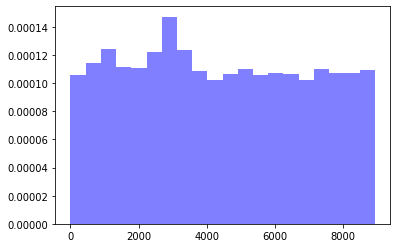

In [198]:
plt.hist(base_distro, 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

### Check some random groups

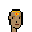

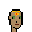

In [239]:
import random

for punk in gt[random.choice(list(key for key in gt.keys()
                                  if len(gt[key]) > 1))]:
    img = Image.open(punk)
    img = img.resize((32, 32))
    display(img)

### Check some of the most common groups

If some look too heterogeneous, we might want to increase the hash size

Bucket: cc633964c9b3ccc993366619c649c699e679


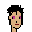

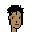

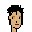

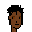

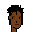

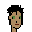

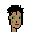

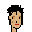

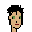

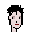

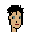

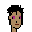

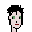

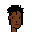

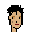

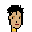

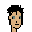

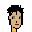

Bucket: cc633964c9b3ccc993266619c649e699e679


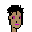

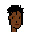

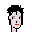

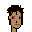

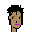

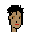

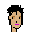

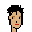

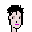

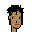

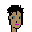

Bucket: cf330c6699a6cc999367239936cce69a6319


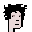

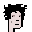

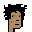

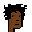

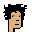

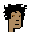

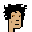

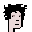

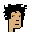

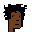

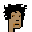

Bucket: cc633964d9b364c31b664999c66666999679


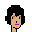

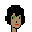

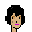

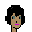

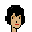

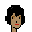

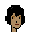

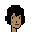

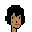

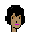

Bucket: cc633966d9b39cc39b6662199869964d9665


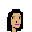

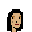

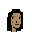

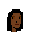

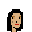

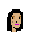

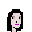

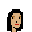

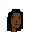

In [199]:
import random

for bucket in [gt_key_distro[p[0]] for p in Counter(base_distro).most_common(5)]:
    print(f'Bucket: {bucket}')
    for punk in gt[bucket]:
        img = Image.open(punk)
        img = img.resize((32, 32))
        display(img)    

# Analysis of training with 500+ epochs (2021-11-15)

Previously I downloaded the model for every 50 epochs and generated 100 individual punks in different folders using model/generate_punks.py

In [200]:
gt_key_distro = list(sorted(gt.keys()))
    
def calculate_metrics(output_folder: str) -> dict:
    n_collisions = 0
    n_new = 0
    new_punk_files = []

    collisions_distro = []

    for punk_file in get_all_punk_files(output_folder, 'result*png'):
        h_ = hash_image(punk_file, method, hash_size)
        if h_ in gt:
            n_collisions += 1
            collisions_distro.append(gt_key_distro.index(h_))
        else:
            n_new += 1
            new_punk_files.append(punk_file)

    return {
        'new_punks': n_new,
        'similar_punks': n_collisions,
        'similar_distro_spread': (max(collisions_distro) - min(collisions_distro)
                                  if len(collisions_distro) > 0 else 0),
        'similar_avg_group_size': (len(collisions_distro) / len(set(collisions_distro))
                                   if len(collisions_distro) > 0 else 0),
        'collisions_distro': collisions_distro,
        'output_folder': output_folder
    }

In [201]:
df_data = [calculate_metrics(f'train_analysis_2021_11_15/{iteration}')
           for iteration in [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]]

In [202]:
import pandas as pd

df = pd.DataFrame(df_data)

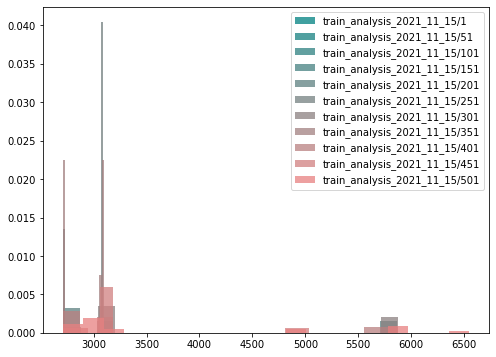

In [210]:
plt.figure(figsize=(8,6))

incr = 1/len(df_data)

for i in range(0, len(df_data)):
    plt.hist(df_data[i]['collisions_distro'], 20,
             density=True, histtype='bar', facecolor=(incr*i, 0.5, 0.5, 0.5), alpha=0.75,
             label=df_data[i]['output_folder'])

plt.legend(loc='upper right')
plt.show()

<AxesSubplot:>

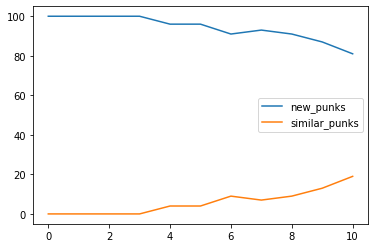

In [204]:
df[['new_punks', 'similar_punks']].plot()

<AxesSubplot:>

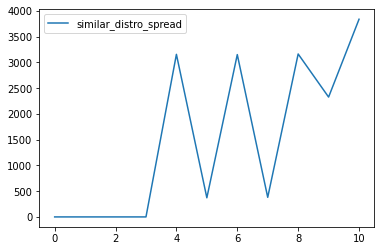

In [205]:
df[['similar_distro_spread']].plot()

## What are the punks that mostly appear at the end?

In [206]:
from collections import Counter

In [207]:
distro = df_data[-1]['collisions_distro']

Bucket: cf230c66b9b6c7999636761963c8c69a6619


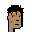

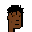

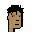

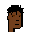

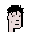

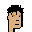

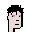

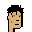

Bucket: cc633966c9b39cc39b6666199869a64d9665


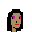

Bucket: cc633966d9b39cc31b6662199c69926d9665


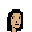

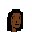

Bucket: cc633966c9b39cc39b6666199c69866d9661


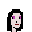

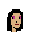

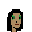

Bucket: cf238c34f30c6799b2ce7c987193cb326638


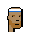

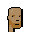

In [208]:
import random

for bucket in [gt_key_distro[p[0]] for p in Counter(distro).most_common(5)]:
    print(f'Bucket: {bucket}')
    for punk in gt[bucket]:
        img = Image.open(punk)
        img = img.resize((32, 32))
        display(img)    